In [1]:
!pip install torchviz

In [2]:
# Setting some hyperparameters and making sure we have a GPU
%matplotlib inline
import numpy as np 
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import random
from torchviz import make_dot

# Set the device to use (cuda is GPU)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Fix random seed for reproducibility
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

cpu


In [3]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torchvision.io import read_image

class UterusDataset(Dataset):
    """Uterus dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Arguments:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """

        # iterate through frame and put it in a hashmap 
        frame = pd.read_csv(csv_file)
        self.hashmap = {}
        for i in range(len(frame)):
            slide_id = frame.iloc[i,0]
            tissue_type = frame.iloc[i,1]
            self.hashmap[slide_id] = tissue_type

        # iterate through all files in root dir & check that png
        self.all = os.listdir(root_dir)
        for item in self.all:
            if not item.endswith('.png'):
                self.all.remove(item)
            
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.all)

    def __getitem__(self, idx):

        img_name = os.path.join(self.root_dir,
                                self.all[idx])
        image = read_image(img_name)

        identif = self.all[idx][0:12]
        label = self.hashmap[identif]
        
        # store as class var
        sample = {'image': image, 'label': label, 'name': identif}

        if self.transform:
            sample = self.transform(sample)

        return sample['image'], sample['label'], sample['name']

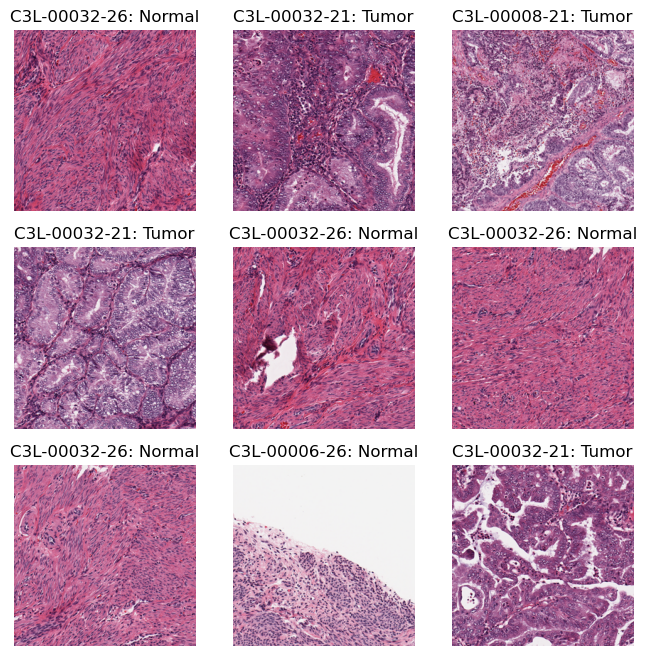

In [208]:
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Uterus dataset
train_dataset = UterusDataset(
    csv_file='/Users/spittignano/Desktop/COS398/UterineHistologyClassification/train_labels.csv', 
    root_dir='/Users/spittignano/Desktop/COS398/train_FILTERING/', transform=None)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, drop_last=True)

label_map = {0 : 'Normal',
             1 : 'Tumor'
            }

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
    img, label, name = train_dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    title = name + ": " + label_map[label]
    plt.title(title)
    plt.axis('off')
    plt.imshow(img.permute(1, 2, 0))
plt.show()

In [4]:
import torch.nn as nn
import torch.nn.functional as F

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 5, padding=2) # 256 input chanels, 256 output chanels, 5x5 kernel size
        self.pool1 = nn.MaxPool2d(2, 2) # 2x2 kernel, 2 stride
        self.conv2 = nn.Conv2d(32, 64, 5, padding=2) # 32 input chanels, 64 output chanels, 5x5 kernels
        self.pool2 = nn.MaxPool2d(2, 2) # 2x2 kernel, 2 stride
        self.size_linear = 64*64*64 # 64 channels, each of size 64-by-64
        self.fc1 = nn.Linear(self.size_linear, 512)
        self.fc2 = nn.Linear(512, 2)
    
    def forward(self, x):
        x = x.float()
        x = self.pool1(F.relu(self.conv1(x))) # we provide this line for you
        x = self.pool2(F.relu(self.conv2(x))) # Apply the second convolution and max pooling
        x = x.view(-1, self.size_linear) # this flattens x into a 1D vector
        x = F.relu(self.fc1(x)) # Apply the first fully connected layer and ReLU
        x = self.fc2(x) # Apply the second fully connected layer (no ReLU)
        x = torch.softmax(x, dim=1)
        return x

In [211]:
class Trainer():
    def __init__(self,net=None,optim=None,loss_function=None, train_loader=None):
        self.net = net
        self.optim = optim
        self.loss_function = loss_function
        self.train_loader = train_loader

    def train(self,epochs):
        losses = []
        for epoch in range(epochs):
            epoch_loss = 0.0
            epoch_steps = 0
            for data in self.train_loader:
                
                # Moving this batch to GPU
                X = data[0].to(device)
                y = data[1].to(device)
            
                # zero the gradient in the optimizer
                self.optim.zero_grad() 
                
                # output of the network
                output = self.net(X)
                
                # compute loss using loss function
                loss = self.loss_function(output, y)
                
                # backpropagate to compute gradients of parameters
                loss.backward()
                
                # call optimizer
                self.optim.step()

                epoch_loss += loss.item()
                epoch_steps += 1
            
            # average loss of epoch
            losses.append(epoch_loss / epoch_steps)
            print("epoch [%d]: loss %.3f" % (epoch+1, losses[-1]))
        return losses

In [212]:
import torch.optim as optim

learning_rate = 0.0000001 #ACT16

net = ConvNet()
net = net.to(device)
opt = optim.Adam(net.parameters(), lr=learning_rate)
loss_function = nn.CrossEntropyLoss()

trainer = Trainer(net=net, optim=opt, loss_function=loss_function, train_loader=train_loader)

num_epochs = 10
losses = trainer.train(num_epochs)

epoch [1]: loss 0.664
epoch [2]: loss 0.588
epoch [3]: loss 0.554
epoch [4]: loss 0.525
epoch [5]: loss 0.516
epoch [6]: loss 0.498
epoch [7]: loss 0.485
epoch [8]: loss 0.472
epoch [9]: loss 0.479
epoch [10]: loss 0.468


In [ ]:
PATH = '/Users/spittignano/Desktop/test'
torch.save(net.state_dict(), PATH)
net2 = ConvNet()
net2.load_state_dict(torch.load(PATH))
model.eval()

In [189]:
test_dataset = UterusDataset(
    csv_file='/Users/spittignano/Desktop/COS398/UterineHistologyClassification/train_labels.csv', 
    root_dir='/Users/spittignano/Desktop/COS398/train_patches_filtered/', transform=None)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)
trainer = Trainer(net=net, optim=opt, loss_function=loss_function, train_loader=test_loader)
num_epochs = 10
losses = trainer.train(num_epochs)

epoch [1]: loss 0.387
epoch [2]: loss 0.385
epoch [3]: loss 0.379
epoch [4]: loss 0.372
epoch [5]: loss 0.369
epoch [6]: loss 0.366
epoch [7]: loss 0.363
epoch [8]: loss 0.360
epoch [9]: loss 0.357
epoch [10]: loss 0.355


In [194]:
PATH = '/Users/spittignano/Desktop/conv_net'
torch.save(net.state_dict(), PATH)

<All keys matched successfully>

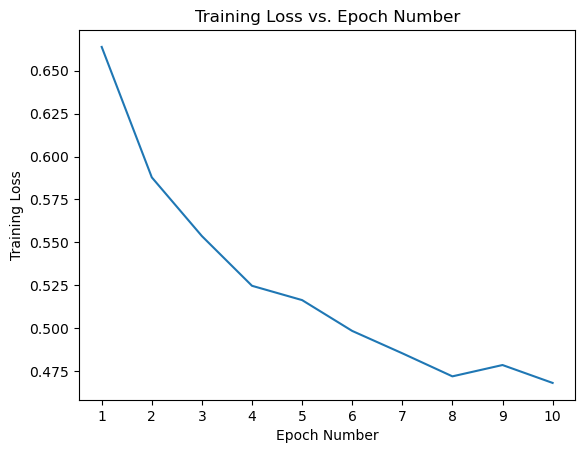

In [213]:
import matplotlib.pyplot as plt
# plot the training loss (y-axis) vs epoch number (x-axis)
epoch = [1,2,3,4,5,6,7,8,9,10]
plt.plot(epoch, losses)
plt.xticks(epoch)
plt.title("Training Loss vs. Epoch Number")
plt.xlabel("Epoch Number")
plt.ylabel("Training Loss")
plt.show()

In [ ]:
PATH = '/Users/spittignano/Desktop/conv_net'
net2.load_state_dict(torch.load(PATH))
model.eval()

In [ ]:
import torch.optim as optim
learning_rate = 0.0000001

opt = optim.Adam(net2.parameters(), lr=learning_rate)
loss_function = nn.CrossEntropyLoss()

trainer = Trainer(net=net2, optim=opt, loss_function=loss_function, train_loader=train_loader)

num_epochs = 10
losses = trainer.train(num_epochs)

In [ ]:
PATH = '/Users/spittignano/Desktop/conv_net_2'
torch.save(net.state_dict(), PATH)

In [ ]:
import matplotlib.pyplot as plt
# plot the training loss (y-axis) vs epoch number (x-axis)
epoch = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
losses_arr = [0.578, 0.535, 0.523, 0.517, 0.509, 0.513, 0.505, 0.504, 0.497, 0.495, 0.492,
              0.491, 0.484, 0.483, 0.479, 0.473, 0.474, 0.471, 0.464, 0.465]
plt.plot(epoch, losses_arr)
plt.xticks(epoch)
plt.title("Training Loss vs. Epoch Number")
plt.xlabel("Epoch Number")
plt.ylabel("Training Loss")
plt.show()

In [216]:
from sklearn.metrics import auc
# Accuracy of our network on test data
test_dataset = UterusDataset(
    csv_file='/Users/spittignano/Desktop/COS398/UterineHistologyClassification/test_labels.csv', 
    root_dir='/Users/spittignano/Desktop/COS398/test_FILTERING/', transform=None)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)
hashmap = {}
with torch.no_grad():
    for data in test_loader:
        X = data[0].to(device)
        y = data[1].to(device)
        name = data[2]
        
        # raw output of network for X
        output = net2(X)
        
        for i in range(len(name)):
            tumor = output[i][1].item()
            if name[i] not in hashmap:
                hashmap[name[i]] = [tumor]
            else:
                hashmap[name[i]].append(tumor)

{'C3L-00086-26': 0, 'C3L-00086-21': 1, 'C3L-00090-26': 0, 'C3L-00090-21': 1}


In [217]:
true_pos = 0
false_pos = 0

true_neg = 0
false_neg = 0

error = 0
total = len(hashmap)

avg_arr = []

for item in hashmap:
    avg = np.mean(hashmap[item])
    avg_arr.append(avg)
    true_value = test_dataset.hashmap[item]
    
    # true value is normal tissue
    if (true_value == 0):
        if (avg > 0.5):
            false_pos += 1
            error += 1
        else:
            true_neg += 1
    
    # true value is tumor tissue
    else:
        if (avg > 0.5):
            true_pos += 1
        else:
            false_neg += 1
            error += 1
        
# TP, FP, FN, Accuracy
print("true pos: %d" % true_pos)
print("false pos: %d" % false_pos)
print("true neg: %d" % true_neg)
print("false neg: %d" % false_neg)
print('Accuracy: %5.2f%%' % (100-100 * error / total))

# TPR = TP / (TP + FN)
TPR = true_pos / (true_pos + false_neg)
print('True positive rate: %5.2f%%' % (TPR*100))
# FPR = FP / (FP + TN)
FPR = false_pos / (false_pos + true_neg)
print('False positive rate: %5.2f%%' % (FPR*100))

#TNR = TN / (FP + TN)
print('True negative rate: %5.2f%%' % ((true_neg / (false_pos + true_neg))*100))
# FNR = FN / (TP + FN)
print('False negative rate: %5.2f%%' % ((false_neg / (true_pos + false_neg))*100))

C3L-00090-21
0.9976751063215105
C3L-00090-26
0.6581216873601079
C3L-00086-21
0.8254496299730235
C3L-00086-26
0.29981973027782655
1
4
true pos: 2
false pos: 1
true neg: 1
false neg: 0
Accuracy: 75.00%
True positive rate: 100.00%
False positive rate: 50.00%
True negative rate: 50.00%
False negative rate:  0.00%


[1, 1, 1, 0, 0, 0]
[0.9354343313025311, 0.8892708044303091, 0.9325846435680781, 0.07062096322964256, 0.039521531472980445, 0.028729456911064887]
[0. 0. 0. 1.]
[0.         0.33333333 1.         1.        ]
[1.93543433 0.93543433 0.8892708  0.02872946]


1.0

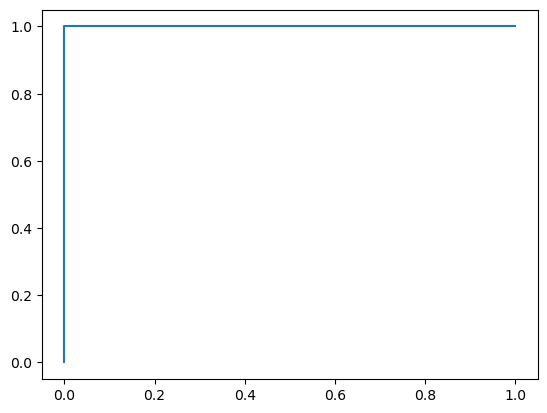

In [192]:
import numpy as np
from sklearn import metrics
y = []
pred = []
for item in hashmap:
    avg = np.mean(hashmap[item])
    pred.append(avg)
    true_value = test_dataset.hashmap[item]
    y.append(true_value)
fpr, tpr, thresholds = metrics.roc_curve(y, pred, pos_label=1)
plt.plot(fpr, tpr)
plt.title("AUC-ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
metrics.auc(fpr, tpr)

In [ ]:
# iterate through frame and put it in a hashmap 
csv_file='/Users/spittignano/Desktop/COS398/UterineHistologyClassification/ethnicity.csv'
frame = pd.read_csv(csv_file)
asian_hashmap = {}
white_hashmap = {}
black_hashmap = {}
for i in range(len(frame)):
    slide_id = frame.iloc[i,0]
    tissue_type = frame.iloc[i,1]
    race = frame.iloc[i, 2]
    if (race == "asian"):
        asian_hashmap[slide_id] = tissue_type
    elif (race == "black or african american"):
        black_hashmap[slide_id] = tissue_type
    else:
        white_hashmap[slide_id] = tissue_type

In [ ]:
def ethncity_calculation(ethnicity_hashmap, race):
    true_pos = 0
    false_pos = 0

    true_neg = 0
    false_neg = 0

    error = 0
    total = 0

    avg_arr = []

    for item in ethnicity_hashmap:
        if item not in hashmap:
            continue
        avg = np.mean(hashmap[item])
        avg_arr.append(avg)
        true_value = ethnicity_hashmap[item]
    
        # true value is normal tissue
        if (true_value == 0):
            if (avg > 0.5):
                false_pos += 1
                error += 1
            else:
                true_neg += 1
    
        # true value is tumor tissue
        else:
            if (avg > 0.5):
                true_pos += 1
            else:
                false_neg += 1
                error += 1
        total += 1
        
    # TP, FP, FN, Accuracy
    print("true pos: %d" % true_pos)
    print("false pos: %d" % false_pos)
    print("true neg: %d" % true_neg)
    print("false neg: %d" % false_neg)
    print("error: %d" % error)
    print("total: %d" % total)
    print('Accuracy: %5.2f%%' % (100-100 * error / total))

    # TPR = TP / (TP + FN)
    TPR = true_pos / (true_pos + false_neg)
    print('True positive rate: %5.2f%%' % (TPR*100))
    # FPR = FP / (FP + TN)
    FPR = false_pos / (false_pos + true_neg)
    print('False positive rate: %5.2f%%' % (FPR*100))

    #TNR = TN / (FP + TN)
    print('True negative rate: %5.2f%%' % ((true_neg / (false_pos + true_neg))*100))
    # FNR = FN / (TP + FN)
    print('False negative rate: %5.2f%%' % ((false_neg / (true_pos + false_neg))*100))
    y = []
    pred = []
    for item in ethnicity_hashmap:
        if item not in hashmap:
            continue
        avg = np.mean(hashmap[item])
        pred.append(avg)
        true_value = ethnicity_hashmap[item]
        y.append(true_value)
    fpr, tpr, thresholds = metrics.roc_curve(y, pred, pos_label=1)
    plt.plot(fpr, tpr)
    plt.title("AUC-ROC Curve: " + race)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.show()
    print(metrics.auc(fpr, tpr))

In [ ]:
ethncity_calculation(asian_hashmap, "Asian")

In [ ]:
ethncity_calculation(black_hashmap, "Black or African American")

In [ ]:
ethncity_calculation(white_hashmap, "White")